In [3]:
import pandas as pd
import numpy as np
import time
import scanpy as sc
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from anndata import AnnData
from anndata.experimental.pytorch import AnnLoader
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import TruncatedSVD

import biomart
import prototypical_network
import helper_fns
import vanilla_vae
from model import PL, Net, train, train_knn, train_logistic_regression

In [4]:
dataset_popv = sc.read("/Volumes/SSD/popv_immune.h5ad")
dataset_celltypist = sc.read("/Volumes/SSD/global.h5ad")
list_celltypes = dataset_popv.obs['cell_type'].unique().tolist()
list_celltypes = list(filter(lambda x: x not in ['myeloid dendritic cell', 'double-positive, alpha-beta thymocyte'], list_celltypes))
dataset_popv = dataset_popv[dataset_popv.obs['cell_type'].isin(list_celltypes)]

encoder_celltype = LabelEncoder()
encoder_celltype.fit(dataset_popv.obs['cell_type'])
list_ct = dataset_popv.obs['cell_type'].unique().tolist()
list_num_ct = encoder_celltype.transform(list_ct)

# myeloid dendritic cell was added as inner node beacuse there are only 3 cells in the dataset
list_inner_nodes = ['popv_immune', 'myeloid leukocyte', 'mature B cell', 'NK', 'CD4', 'CD8', 'myeloid dendritic cell']
all_nodes = list_ct + list_inner_nodes

encoder_celltype_inner = LabelEncoder()
encoder_celltype_inner.fit(list_inner_nodes)

g = helper_fns.build_hierarchical_tree_popv_immune(all_nodes=all_nodes, list_ct=list_ct, list_inner_nodes=list_inner_nodes, encoder_celltype=encoder_celltype, encoder_celltype_inner=encoder_celltype_inner)

dist_df = helper_fns.get_dist_df(list_num_ct=list_num_ct, g=g)
D = torch.tensor(dist_df.values, dtype=float)
ensembl_to_genesymbol = helper_fns.get_ensembl_mappings()

genes_celltypist = dataset_celltypist.var_names
genes_popv = dataset_popv.var_names
not_found = []
found_hgnc = []
found_ensembl = []
for i in range(len(list(genes_celltypist))):
    try:
        a = ensembl_to_genesymbol[genes_celltypist[i]]
        if a not in genes_popv:
            not_found.append(genes_celltypist[i])
        else:
            found_hgnc.append(genes_celltypist[i])
            found_ensembl.append(a)
    except KeyError:
        not_found.append(genes_celltypist[i])

# filter the anndata by the found_ensembl genes
dataset_popv = dataset_popv[:,found_ensembl]
dataset_celltypist = dataset_celltypist[:,found_hgnc]

train_indices, test_indices, cv = helper_fns.costumized_train_test_split(dataset_popv, cross_validation=False, k_fold=5, obs_key='cell_type')
sc.pp.normalize_total(dataset_popv, 1e4)
sc.pp.log1p(dataset_popv)
sc.pp.highly_variable_genes(dataset_popv)
highly_variable_genes = dataset_popv.var['highly_variable']
dataset_popv = dataset_popv[:,highly_variable_genes]
pca = TruncatedSVD(n_components=128, random_state=0)
pca.fit(dataset_popv[train_indices].X)
dataset_popv_pca = AnnData(pca.transform(dataset_popv.X))
dataset_popv_pca.obs = dataset_popv.obs

train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)

# Define data loaders for training and testing data in this fold
encoders = {
    'obs': {
        'cell_type': encoder_celltype.transform
    }
}
dataloader_training = AnnLoader(dataset_popv_pca, batch_size=512, convert=encoders, sampler=train_subsampler)
dataloader_testing = AnnLoader(dataset_popv_pca, batch_size=512, convert=encoders, sampler=test_subsampler)


# Label encoder // No problem
encoder_celltype_celltypist = LabelEncoder()
encoder_celltype_celltypist.fit(dataset_celltypist.obs['Manually_curated_celltype'])

sc.pp.normalize_total(dataset_celltypist, 1e4)
sc.pp.log1p(dataset_celltypist)
dataset_celltypist = dataset_celltypist[:,highly_variable_genes]
dataset_celltypist_pca = AnnData(pca.transform(dataset_celltypist.X))
dataset_celltypist_pca.obs = dataset_celltypist.obs

/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/Users/xbh0403/Desktop/HCell/model.py:88: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  centers = torch.tensor(centers, dtype=float)


Epoch 1
Train ER 48.43, time 6.9s
Test ER 42.88, time 0.7s
Epoch 2
Train ER 39.02, time 6.6s
Test ER 35.75, time 0.7s
Epoch 3
Train ER 33.26, time 6.7s
Test ER 31.27, time 0.6s
Epoch 4
Train ER 30.19, time 6.8s
Test ER 29.24, time 0.6s
Epoch 5
Train ER 28.55, time 6.5s
Test ER 28.07, time 0.7s
Epoch 6
Train ER 27.17, time 6.4s
Test ER 27.09, time 0.6s
Epoch 7
Train ER 26.12, time 6.5s
Test ER 26.18, time 0.6s
Epoch 8
Train ER 25.28, time 6.6s
Test ER 25.67, time 0.6s
Epoch 9
Train ER 24.69, time 6.6s
Test ER 25.06, time 0.6s
Epoch 10
Train ER 24.25, time 6.6s
Test ER 24.77, time 0.7s
Epoch 11
Train ER 23.86, time 6.6s
Test ER 24.57, time 0.7s
Epoch 12
Train ER 23.54, time 6.7s
Test ER 24.45, time 0.7s
Epoch 13
Train ER 23.27, time 6.5s
Test ER 24.28, time 0.6s
Epoch 14
Train ER 23.12, time 6.6s
Test ER 24.03, time 0.6s
Epoch 15
Train ER 22.84, time 6.6s
Test ER 23.85, time 0.6s
Epoch 16
Train ER 22.73, time 6.9s
Test ER 23.75, time 0.7s
Epoch 17
Train ER 22.51, time 6.6s
Test ER 23.57,

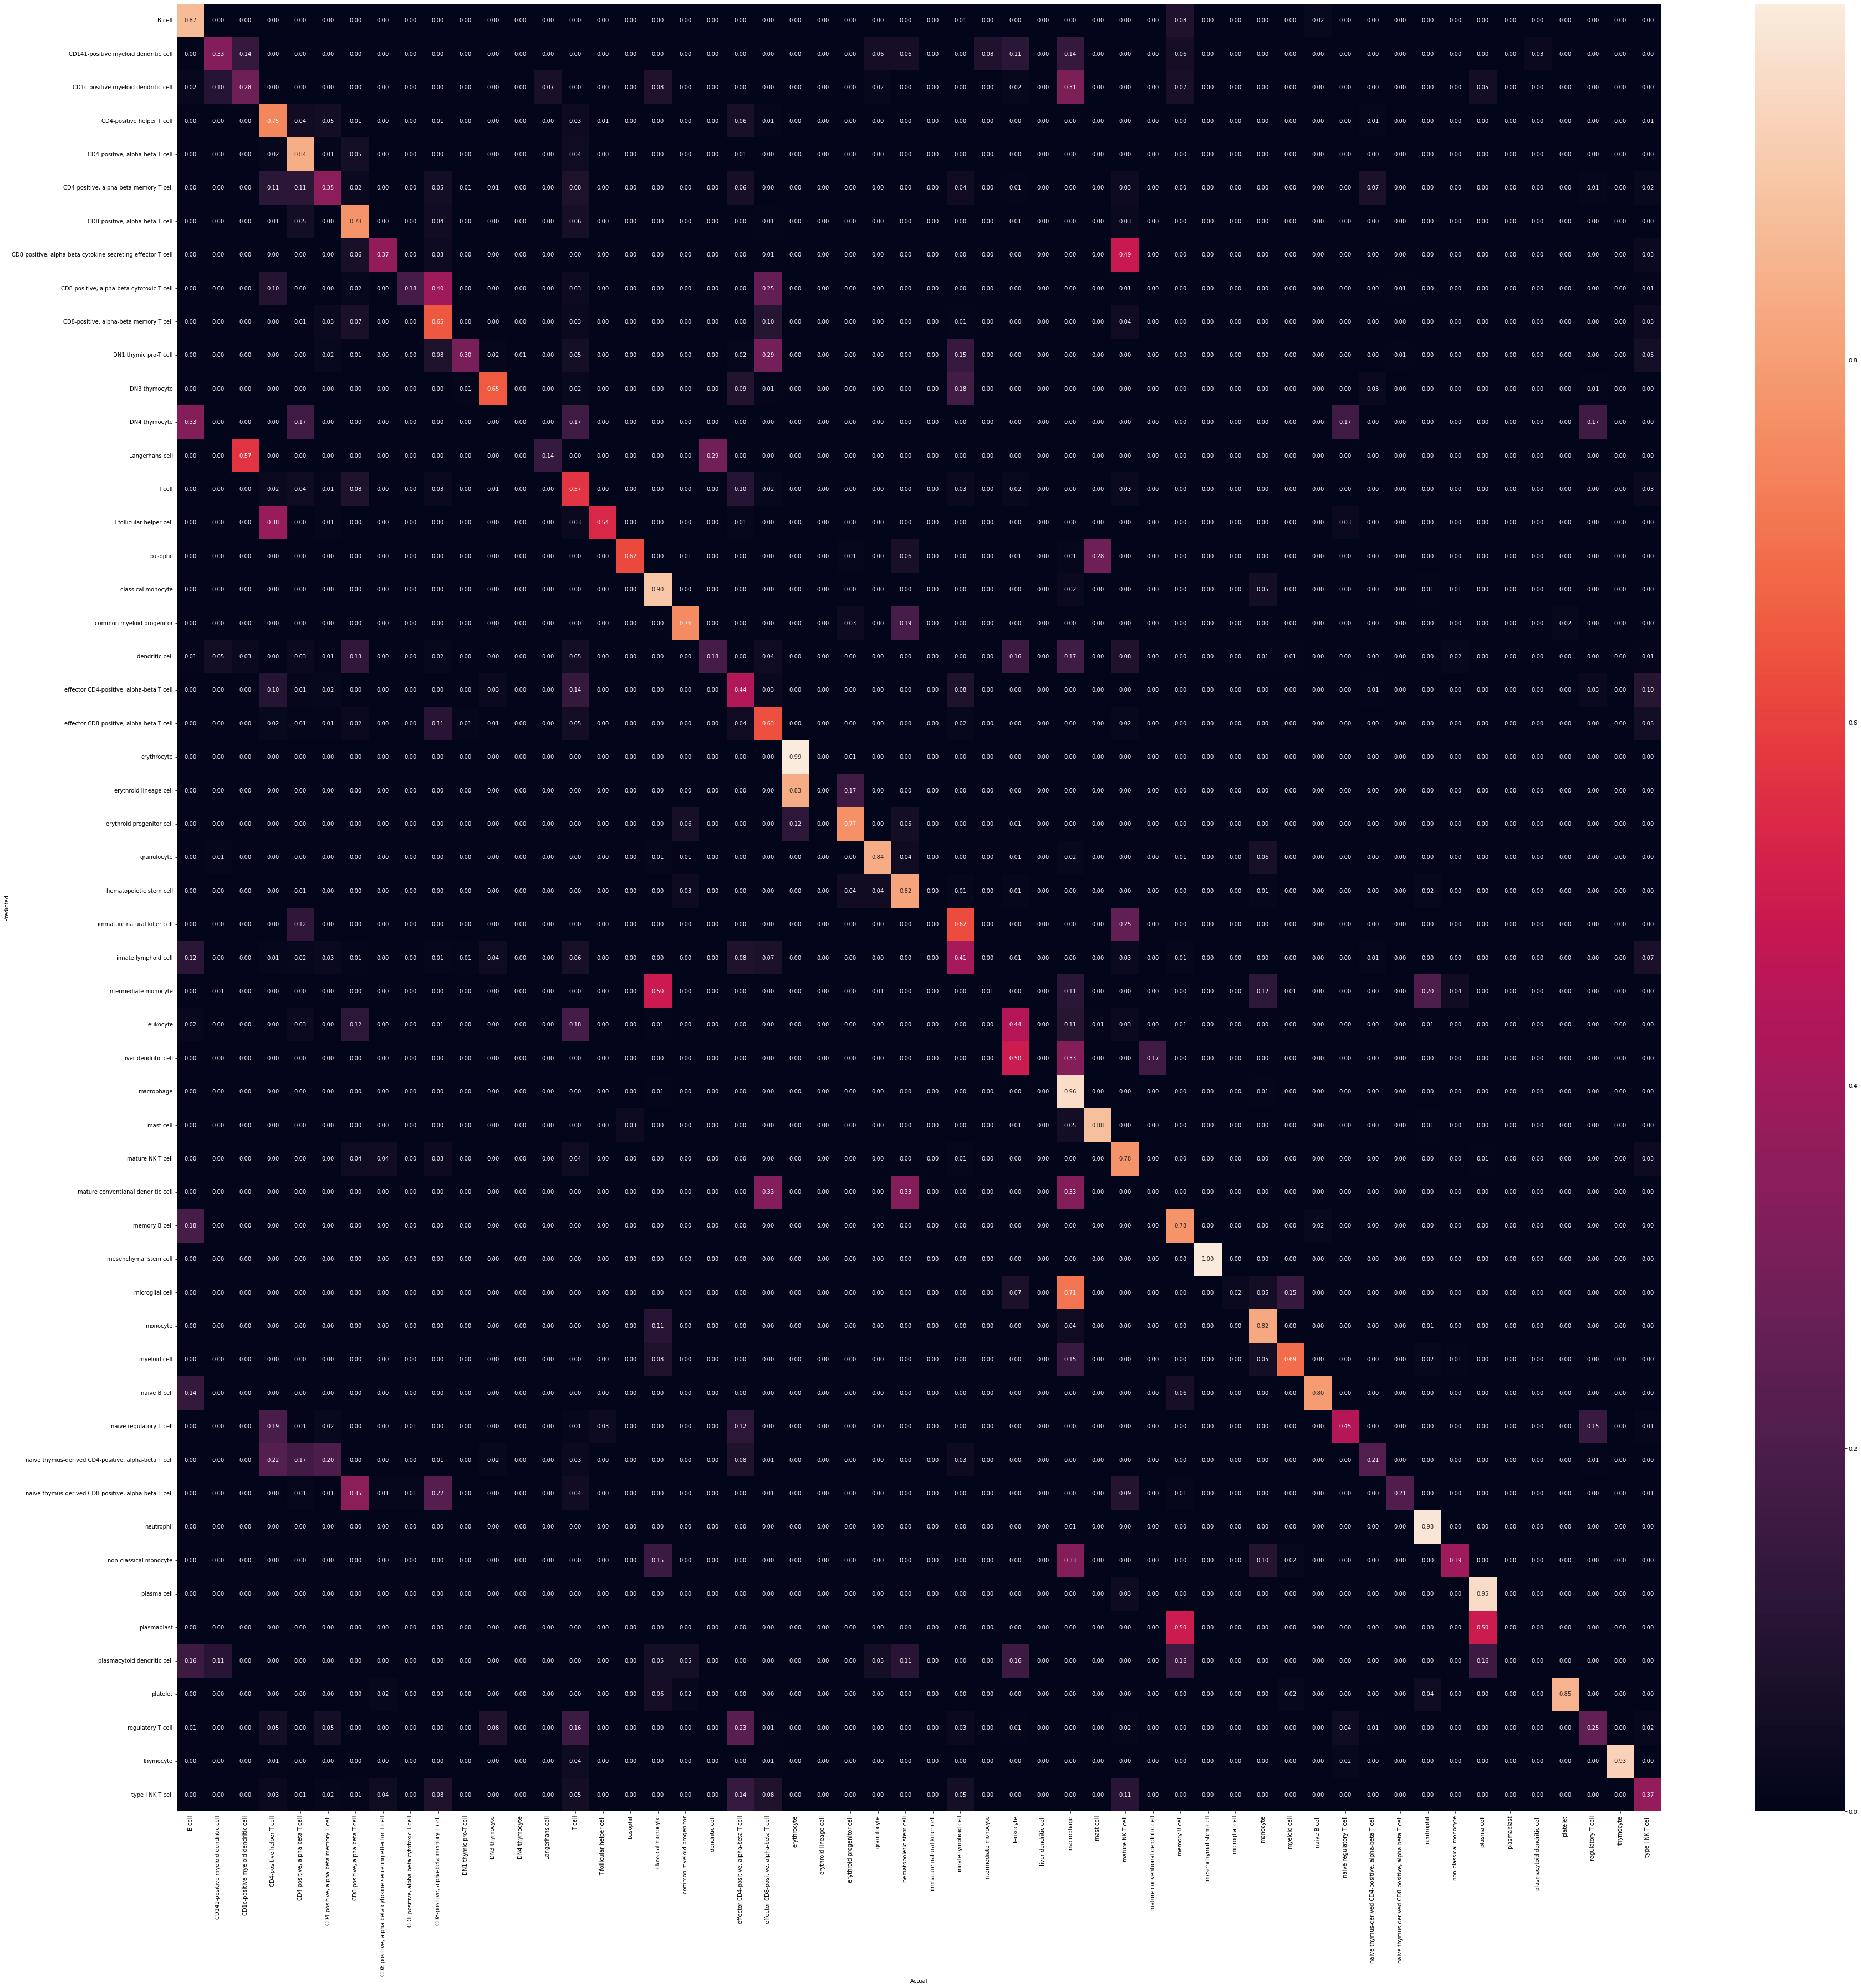

In [5]:
weights = helper_fns.get_weights(num_celltypes=len(list_num_ct), dataset=dataset_popv_pca, encoder=encoder_celltype, obs='cell_type')
model = train(mode='Proto_Net', loss_mode='disto_pl', epochs=50, embedding_dim=16, D=D, num_celltypes=list_num_ct, 
    encoder=encoder_celltype, dataset=dataset_popv_pca, dataloader_training=dataloader_training, dataloader_testing=dataloader_testing, 
    obs_name='cell_type', init_weights=weights)
embedding_prototypes, embedding_prototypes_labels = helper_fns.get_prototypes_and_labels(model=model, encoder=encoder_celltype, num_celltypes=len(list_num_ct))
helper_fns.plot_confusion_matrix('Proto_Net', model, dataset=dataset_popv_pca, encoder=encoder_celltype, test_indices=test_indices, obs_name='cell_type', size=60)

In [6]:
model_logistic = train_logistic_regression(dataset=dataset_popv_pca, train_indices=train_indices, test_indices=test_indices, encoder=encoder_celltype, obs_name='cell_type')
model_knn = train_knn(dataset=dataset_popv_pca, train_indices=train_indices, test_indices=test_indices, encoder=encoder_celltype, obs_name='cell_type')

/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Train error: 27.528365647831755%
Test error: 28.357165794593776%
kNN
Train error: 18.381978138156285%
Test error: 26.186743232777342%


In [7]:
test_celltypes = ['Memory B cells', 'Naive B cells', 'Tfh', 'Plasma cells', 'Tregs']
train_celltypes = ['memory B cell', 'naive B cell', 'T follicular helper cell', 'plasma cell', 'regulatory T cell']

In [8]:
train_embeddings, training_preds = helper_fns.get_embeddings_and_out(model, dataset_popv_pca[train_indices], encoder=encoder_celltype)
test_embeddings, test_preds = helper_fns.get_embeddings_and_out(model, dataset_celltypist_pca, encoder=encoder_celltype)
prototypes, prototypes_labels = helper_fns.get_prototypes_and_labels(model, encoder=encoder_celltype, num_celltypes=len(list_num_ct))

In [9]:
# helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
#  train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
#  test_pred_labels=test_preds, train_celltype='Memory B cells', test_celltype='memory B cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

In [10]:
# helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
#  train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
#  test_pred_labels=test_preds, train_celltype='Naive B cells', test_celltype='naive B cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

In [11]:
# helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
#  train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
#  test_pred_labels=test_preds, train_celltype='Tfh', test_celltype='T follicular helper cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

In [12]:
# helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
#  train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
#  test_pred_labels=test_preds, train_celltype='Plasma cells', test_celltype='plasma cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

In [13]:
# helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
#  train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
#  test_pred_labels=test_preds, train_celltype='Tregs', test_celltype='regulatory T cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

In [14]:
# helper_fns.plot_embeddings_scatter(embeddings=test_embeddings, true_labels=dataset_popv_pca.obs['cell_type'], 
#     embedding_prototypes=prototypes, embedding_prototypes_labels=prototypes_labels)

In [15]:
# helper_fns.plot_embeddings_scatter(embeddings=train_embeddings, true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], 
#     embedding_prototypes=prototypes, embedding_prototypes_labels=prototypes_labels)

In [16]:
# helper_fns.plot_embeddings_scatter(embeddings=test_embeddings, true_labels=dataset_celltypist_pca[test_indices].obs['Manually_curated_celltype'], 
#     embedding_prototypes=prototypes, embedding_prototypes_labels=prototypes_labels)

In [17]:
# helper_fns.plot_embeddings_likelihood(model=model, encoder=encoder_celltype, pred_labels=training_preds, 
#     embeddings=train_embeddings, prototypes=prototypes, prototypes_labels=prototypes_labels)

In [18]:
# helper_fns.plot_embeddings_likelihood(model=model, encoder=encoder_celltype, pred_labels=test_preds, 
#     embeddings=test_embeddings, prototypes=prototypes, prototypes_labels=prototypes_labels)

In [21]:
def plot_dist_histogram(dict, graph, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner, save, model):
    true_label = dict['Celltype']
    # true_label = 'Memory B cells'
    dist_list = []
    for key in dict.keys():
        if key != 'Celltype' and key != 'true_positive_rate':
            dist = helper_fns.get_shortest_dist(helper_fns.transform(key, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner),
                helper_fns.transform(true_label, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner), graph)
            for i in range(int(dict[key])):
                dist_list.append(dist)
    print(np.array(dist_list).mean())
    sns.displot(dist_list)
    # Add label to the plot
    plt.title(true_label)
    if save:
        plt.savefig('./popv_celltypist_plots_dist/histogram_' + model + true_label + '.png')
    else:
        plt.show()

OUR MODEL


True positive Memory B cells: 8.431609891060003%
{'B cell': 26392, 'naive B cell': 33, 'plasma cell': 11, 'innate lymphoid cell': 11, 'leukocyte': 9, 'CD4-positive, alpha-beta T cell': 6, 'macrophage': 5, 'T cell': 4, 'neutrophil': 4, 'monocyte': 1, 'CD8-positive, alpha-beta T cell': 1}
2.0053631453714544


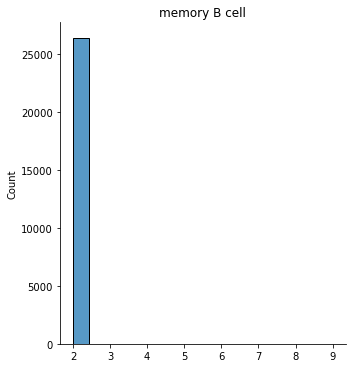



True positive Naive B cells: 11.615945135019288%
{'B cell': 9353, 'memory B cell': 3011, 'plasma cell': 4, 'leukocyte': 2, 'plasmacytoid dendritic cell': 1, 'monocyte': 1}
2.001212415130941


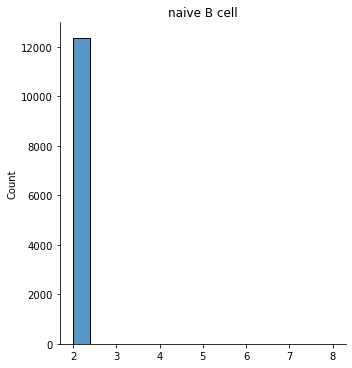



True positive Tfh: 1.2031648466618714%
{'T cell': 5958, 'effector CD4-positive, alpha-beta T cell': 3306, 'innate lymphoid cell': 1857, 'CD4-positive, alpha-beta T cell': 1438, 'type I NK T cell': 1232, 'CD4-positive, alpha-beta memory T cell': 710, 'effector CD8-positive, alpha-beta T cell': 271, 'CD4-positive helper T cell': 119, 'DN3 thymocyte': 55, 'naive thymus-derived CD4-positive, alpha-beta T cell': 41, 'CD8-positive, alpha-beta T cell': 36, 'B cell': 35, 'leukocyte': 25, 'memory B cell': 8, 'CD8-positive, alpha-beta memory T cell': 6, 'mature NK T cell': 5, 'naive regulatory T cell': 3, 'DN1 thymic pro-T cell': 2, 'regulatory T cell': 1, 'classical monocyte': 1}
3.0187967436627177


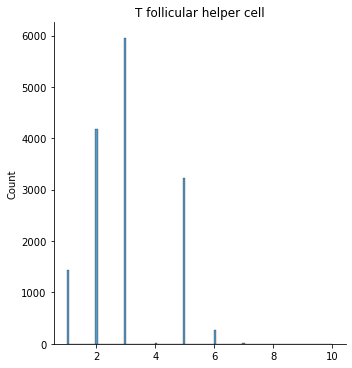



True positive Plasma cells: 99.170653907496%
{'B cell': 38, 'memory B cell': 10, 'innate lymphoid cell': 2, 'leukocyte': 2}
1.5


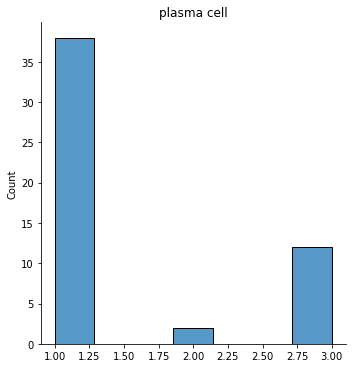



True positive Tregs: 3.5493700074116776%
{'T cell': 5349, 'effector CD4-positive, alpha-beta T cell': 2686, 'CD4-positive, alpha-beta T cell': 1356, 'innate lymphoid cell': 644, 'CD4-positive, alpha-beta memory T cell': 532, 'type I NK T cell': 258, 'DN3 thymocyte': 192, 'effector CD8-positive, alpha-beta T cell': 143, 'T follicular helper cell': 112, 'leukocyte': 108, 'naive regulatory T cell': 100, 'CD4-positive helper T cell': 82, 'naive thymus-derived CD4-positive, alpha-beta T cell': 50, 'B cell': 30, 'CD8-positive, alpha-beta T cell': 25, 'CD8-positive, alpha-beta memory T cell': 13, 'memory B cell': 13, 'DN1 thymic pro-T cell': 8, 'thymocyte': 5, 'mature NK T cell': 3, 'plasma cell': 2, 'macrophage': 1}
1.9601263661202186


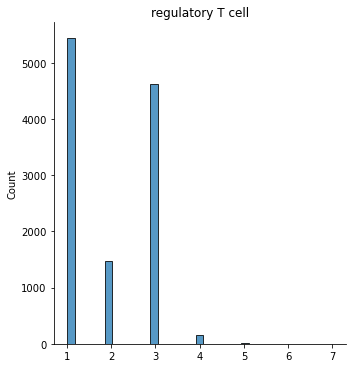



Logistic Regression


True positive Memory B cells: 2.552308490402905%
{'B cell': 28090, 'innate lymphoid cell': 44, 'naive B cell': 19, 'monocyte': 8, 'plasma cell': 5, 'macrophage': 4, 'effector CD8-positive, alpha-beta T cell': 2, 'CD4-positive, alpha-beta T cell': 1, 'T cell': 1, 'CD8-positive, alpha-beta T cell': 1, 'CD4-positive helper T cell': 1, 'leukocyte': 1}
2.0067785782730594


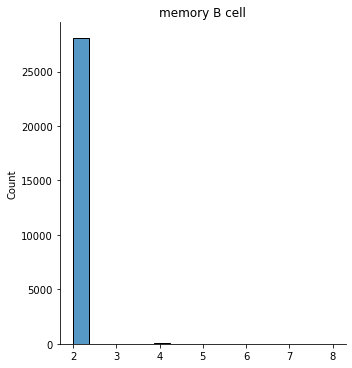



True positive Naive B cells: 9.222746106586657%
{'B cell': 12661, 'memory B cell': 35, 'plasma cell': 3, 'T cell': 2, 'innate lymphoid cell': 2, 'type I NK T cell': 1, 'neutrophil': 1, 'immature natural killer cell': 1, 'CD4-positive helper T cell': 1}
2.002439600220351


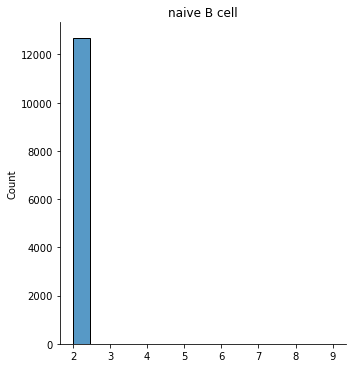



True positive Tfh: 1.3404825737265416%
{'effector CD4-positive, alpha-beta T cell': 7115, 'CD4-positive, alpha-beta T cell': 3136, 'type I NK T cell': 1972, 'T cell': 1278, 'CD4-positive, alpha-beta memory T cell': 445, 'effector CD8-positive, alpha-beta T cell': 387, 'CD4-positive helper T cell': 320, 'innate lymphoid cell': 267, 'naive thymus-derived CD4-positive, alpha-beta T cell': 64, 'CD8-positive, alpha-beta T cell': 32, 'DN3 thymocyte': 24, 'B cell': 22, 'leukocyte': 13, 'thymocyte': 3, 'memory B cell': 2, 'regulatory T cell': 2, 'naive regulatory T cell': 2, 'macrophage': 1, 'CD8-positive, alpha-beta memory T cell': 1, 'plasma cell': 1, 'mature NK T cell': 1}
2.4442603393425237


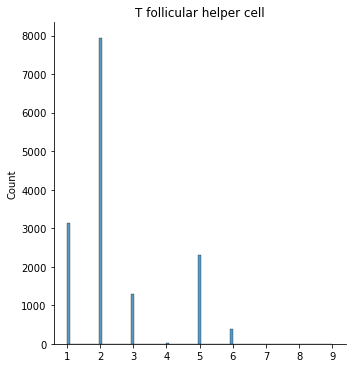



True positive Plasma cells: 95.02392344497608%
{'B cell': 234, 'innate lymphoid cell': 66, 'monocyte': 4, 'macrophage': 3, 'CD1c-positive myeloid dendritic cell': 1, 'effector CD8-positive, alpha-beta T cell': 1, 'erythrocyte': 1, 'plasmacytoid dendritic cell': 1, 'neutrophil': 1}
1.641025641025641


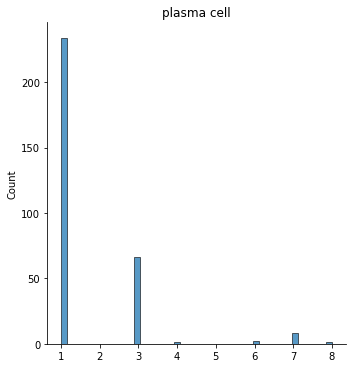



True positive Tregs: 9.865766285102529%
{'effector CD4-positive, alpha-beta T cell': 5211, 'CD4-positive, alpha-beta T cell': 2483, 'T cell': 1357, 'type I NK T cell': 457, 'CD4-positive, alpha-beta memory T cell': 320, 'CD4-positive helper T cell': 273, 'effector CD8-positive, alpha-beta T cell': 176, 'innate lymphoid cell': 125, 'naive regulatory T cell': 110, 'DN3 thymocyte': 105, 'leukocyte': 100, 'naive thymus-derived CD4-positive, alpha-beta T cell': 82, 'T follicular helper cell': 61, 'B cell': 44, 'CD8-positive, alpha-beta T cell': 17, 'mature NK T cell': 11, 'CD8-positive, alpha-beta memory T cell': 4, 'thymocyte': 3, 'macrophage': 2, 'dendritic cell': 1, 'CD8-positive, alpha-beta cytotoxic T cell': 1, 'monocyte': 1, 'naive thymus-derived CD8-positive, alpha-beta T cell': 1}
2.5133851073549565


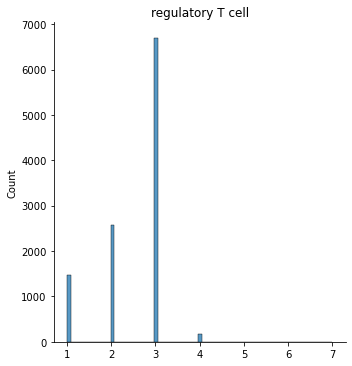



kNN


True positive Memory B cells: 11.796645339789038%
{'B cell': 24694, 'innate lymphoid cell': 488, 'naive B cell': 210, 'CD4-positive, alpha-beta T cell': 29, 'macrophage': 25, 'monocyte': 11, 'leukocyte': 9, 'CD8-positive, alpha-beta T cell': 9, 'CD4-positive helper T cell': 7, 'classical monocyte': 6, 'plasma cell': 5, 'myeloid cell': 4, 'erythrocyte': 3, 'T cell': 3, 'platelet': 1}
2.058030112923463


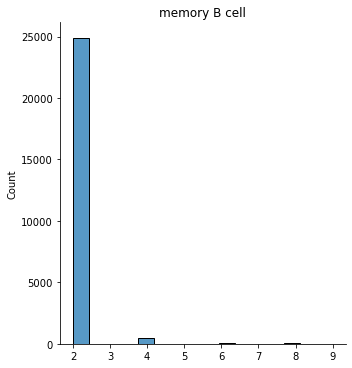



True positive Naive B cells: 37.61251607372482%
{'B cell': 6857, 'memory B cell': 1845, 'innate lymphoid cell': 9, 'CD4-positive, alpha-beta T cell': 7, 'plasma cell': 4, 'CD4-positive helper T cell': 2, 'platelet': 1, 'monocyte': 1, 'myeloid cell': 1, 'erythrocyte': 1, 'CD8-positive, alpha-beta T cell': 1, 'classical monocyte': 1, 'erythroid lineage cell': 1, 'macrophage': 1, 'hematopoietic stem cell': 1}
2.0121378678575517


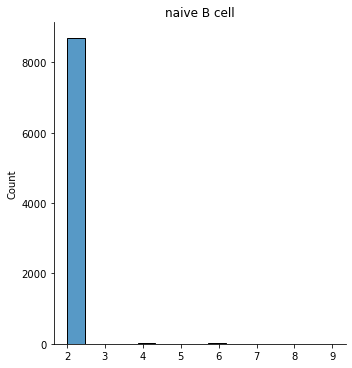



True positive Tfh: 1.9028313607532858%
{'effector CD4-positive, alpha-beta T cell': 3209, 'CD4-positive helper T cell': 2912, 'T cell': 2410, 'CD4-positive, alpha-beta T cell': 1766, 'DN3 thymocyte': 1363, 'innate lymphoid cell': 1177, 'CD4-positive, alpha-beta memory T cell': 772, 'type I NK T cell': 715, 'naive thymus-derived CD4-positive, alpha-beta T cell': 193, 'CD8-positive, alpha-beta T cell': 106, 'leukocyte': 97, 'effector CD8-positive, alpha-beta T cell': 89, 'naive regulatory T cell': 49, 'DN1 thymic pro-T cell': 38, 'B cell': 27, 'thymocyte': 26, 'regulatory T cell': 23, 'CD8-positive, alpha-beta memory T cell': 21, 'monocyte': 3, 'mature NK T cell': 2, 'myeloid cell': 1, 'plasma cell': 1, 'dendritic cell': 1, 'CD8-positive, alpha-beta cytotoxic T cell': 1}
2.778162911611785


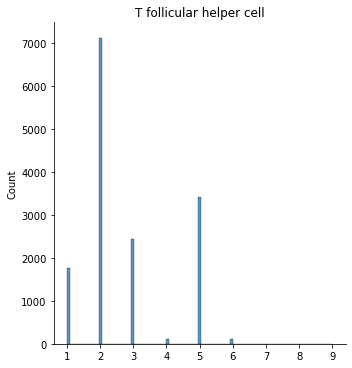



True positive Plasma cells: 99.1866028708134%
{'B cell': 39, 'innate lymphoid cell': 4, 'memory B cell': 3, 'naive B cell': 2, 'CD1c-positive myeloid dendritic cell': 1, 'CD8-positive, alpha-beta T cell': 1, 'macrophage': 1}
1.6470588235294117


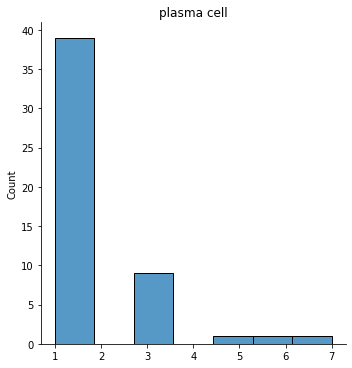



True positive Tregs: 4.965823931483159%
{'CD4-positive helper T cell': 2228, 'effector CD4-positive, alpha-beta T cell': 2192, 'T cell': 1881, 'CD4-positive, alpha-beta T cell': 1587, 'DN3 thymocyte': 933, 'naive regulatory T cell': 807, 'CD4-positive, alpha-beta memory T cell': 633, 'innate lymphoid cell': 305, 'leukocyte': 236, 'type I NK T cell': 200, 'naive thymus-derived CD4-positive, alpha-beta T cell': 131, 'T follicular helper cell': 96, 'B cell': 95, 'CD8-positive, alpha-beta T cell': 85, 'effector CD8-positive, alpha-beta T cell': 55, 'DN1 thymic pro-T cell': 22, 'CD8-positive, alpha-beta memory T cell': 15, 'monocyte': 8, 'CD8-positive, alpha-beta cytotoxic T cell': 6, 'thymocyte': 6, 'macrophage': 4, 'classical monocyte': 4, 'dendritic cell': 3, 'mature NK T cell': 3, 'neutrophil': 2, 'CD8-positive, alpha-beta cytokine secreting effector T cell': 1, 'myeloid cell': 1, 'mesenchymal stem cell': 1}
2.3893414211438473


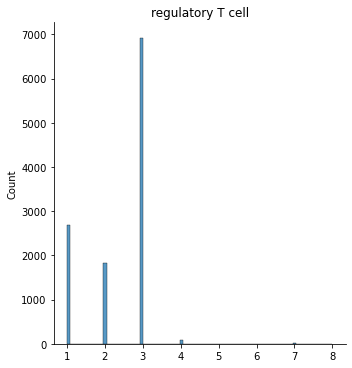

In [22]:
print("OUR MODEL")
wrong_dict_our_model_list = []
for i in range(len(train_celltypes)):
    print('\n')
    wrong_dict_our_model = helper_fns.print_true_positive_given_labels_and_datasets(test_true_labels=dataset_celltypist_pca.obs['Manually_curated_celltype'], test_pred_labels=test_preds, 
        train_celltype=train_celltypes[i], test_celltype=test_celltypes[i])
    mean_dist = plot_dist_histogram(wrong_dict_our_model, g, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner, save=False, model='our_model')
    wrong_dict_our_model_list.append(wrong_dict_our_model)

print('\n')
print("Logistic Regression")
wrong_dict_logistic_regression_list = []
test_preds_logistic = encoder_celltype.inverse_transform(model_logistic.predict(dataset_celltypist_pca.X))
for i in range(len(train_celltypes)):
    print('\n')
    wrong_dict_logistic_regression = helper_fns.print_true_positive_given_labels_and_datasets(test_true_labels=dataset_celltypist_pca.obs['Manually_curated_celltype'], test_pred_labels=test_preds_logistic, 
        train_celltype=train_celltypes[i], test_celltype=test_celltypes[i])
    plot_dist_histogram(wrong_dict_logistic_regression, g, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner, save=False, model='logistic_regression')
    wrong_dict_logistic_regression_list.append(wrong_dict_logistic_regression)

print('\n')
print("kNN")
wrong_dict_knn_list = []
test_preds_knn = encoder_celltype.inverse_transform(model_knn.predict(dataset_celltypist_pca.X))
for i in range(len(train_celltypes)):
    print('\n')
    wrong_dict_knn = helper_fns.print_true_positive_given_labels_and_datasets(test_true_labels=dataset_celltypist_pca.obs['Manually_curated_celltype'], test_pred_labels=test_preds_knn, 
        train_celltype=train_celltypes[i], test_celltype=test_celltypes[i])
    plot_dist_histogram(wrong_dict_knn, g, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner, save=False, model='knn')
    wrong_dict_knn_list.append(wrong_dict_knn)

In [23]:
df_acc = pd.DataFrame(columns=['celltype', 'true_positive_rate', 'model'])
for i in range(len(wrong_dict_our_model_list)):
    # Fill temp_df with the true positive rate for each cell type using pd.concat
    a = pd.DataFrame({
        'celltype': [wrong_dict_our_model_list[i]['Celltype'], wrong_dict_logistic_regression_list[i]['Celltype'], wrong_dict_knn_list[i]['Celltype']],
        'true_positive_rate': [wrong_dict_our_model_list[i]['true_positive_rate'], wrong_dict_logistic_regression_list[i]['true_positive_rate'], wrong_dict_knn_list[i]['true_positive_rate']],
        'model': ['our_model', 'logistic_regression', 'knn']
        })
    df_acc = pd.concat([df_acc, a], ignore_index=True)

In [31]:
df_dist = pd.DataFrame(columns=['celltype', 'pred_celltype', 'dist', 'model'])
for n in range(len(wrong_dict_our_model_list)):
    for key in wrong_dict_our_model_list[n].keys():
        celltype = wrong_dict_our_model_list[n]['Celltype']
        if key != 'Celltype' and key != 'true_positive_rate':
            num = int(wrong_dict_our_model_list[n][key])
            dist = helper_fns.get_shortest_dist(helper_fns.transform(key, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner), 
            helper_fns.transform(celltype, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner), g)
            for i in range(num):
                # concat the new row to the dataframe
                df_dist = pd.concat([df_dist, pd.DataFrame([[celltype, key , dist, 'our_model']], columns=['celltype', 'pred_celltype', 'dist', 'model'])], ignore_index=True)

    for key in wrong_dict_logistic_regression_list[n].keys():
        celltype = wrong_dict_logistic_regression_list[n]['Celltype']
        if key != 'Celltype' and key != 'true_positive_rate':
            num = int(wrong_dict_logistic_regression_list[n][key])
            dist = helper_fns.get_shortest_dist(helper_fns.transform(key, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner), 
            helper_fns.transform(celltype, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner), g)
            for i in range(num):
                # concat the new row to the dataframe
                df_dist = pd.concat([df_dist, pd.DataFrame([[celltype, key , dist, 'logistic']], columns=['celltype', 'pred_celltype', 'dist', 'model'])], ignore_index=True)

    for key in wrong_dict_knn_list[n].keys():
        celltype = wrong_dict_knn_list[n]['Celltype']
        if key != 'Celltype' and key != 'true_positive_rate':
            num = int(wrong_dict_knn_list[n][key])
            dist = helper_fns.get_shortest_dist(helper_fns.transform(key, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner), 
            helper_fns.transform(celltype, list_ct, list_inner_nodes, encoder_celltype, encoder_celltype_inner), g)
            for i in range(num):
                # concat the new row to the dataframe
                df_dist = pd.concat([df_dist, pd.DataFrame([[celltype, key , dist, 'knn']], columns=['celltype', 'pred_celltype', 'dist', 'model'])], ignore_index=True)

In [44]:
mean_dist_our_model = [2.0053631453714544, 2.001212415130941, 3.0187967436627177, 1.5, 1.9601263661202186]
mean_dist_logistic = [2.0067785782730594, 2.002439600220351, 2.4442603393425237, 1.641025641025641, 2.5133851073549565]
mean_dist_knn = [2.058030112923463, 2.0121378678575517, 2.778162911611785, 1.6470588235294117, 2.3893414211438473]
df_mean_dist = pd.DataFrame(columns=['celltype', 'mean_dist', 'model'])
for i in range(len(mean_dist_our_model)):
    # Fill temp_df with the true positive rate for each cell type using pd.concat
    a = pd.DataFrame({
        'celltype': [wrong_dict_our_model_list[i]['Celltype'], wrong_dict_logistic_regression_list[i]['Celltype'], wrong_dict_knn_list[i]['Celltype']],
        'mean_dist': [mean_dist_our_model[i], mean_dist_logistic[i], mean_dist_knn[i]],
        'model': ['our_model', 'logistic_regression', 'knn']
        })
    df_mean_dist = pd.concat([df_mean_dist, a], ignore_index=True)

df_err = pd.DataFrame(columns=['error', 'model', 'type'])
a = pd.DataFrame({
    'error': [20.52, 22.61, 27.528365647831755, 28.357165794593776, 18.381978138156285, 26.186743232777342],
    'model': ['our_model', 'our_model', 'logistic_regression', 'logistic_regression', 'knn', 'knn'],
    'type': ['train', 'test', 'train', 'test', 'train', 'test']
    })
df_err = pd.concat([df_err, a], ignore_index=True)

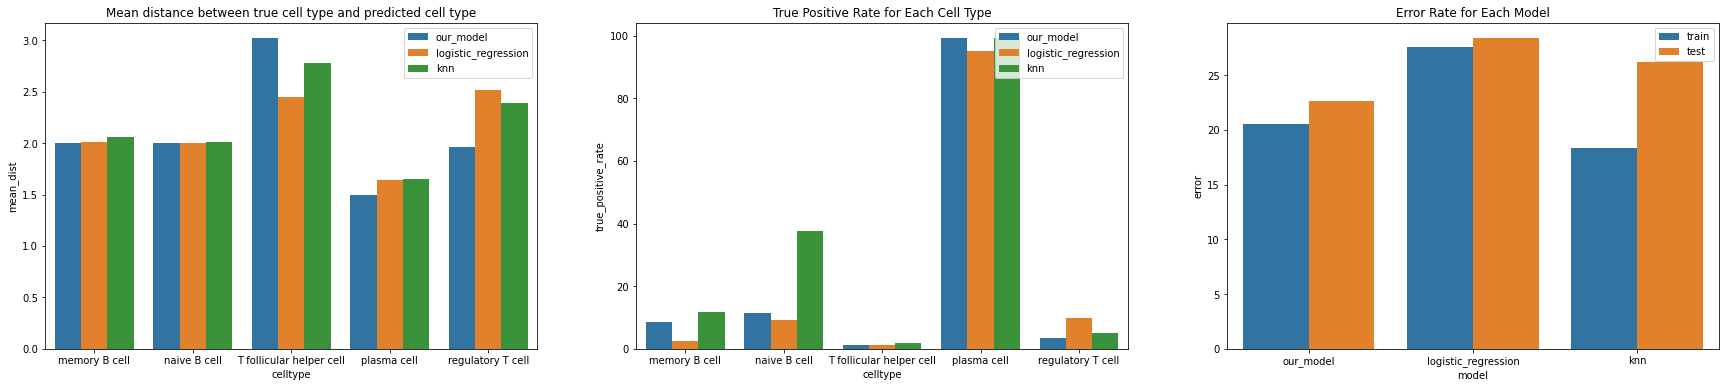

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))
sns.barplot(x='celltype', y='mean_dist', hue='model', data=df_mean_dist, ax=ax1)
ax1.set_title('Mean distance between true cell type and predicted cell type')
ax1.legend(loc='upper right')
ax2 = sns.barplot(data=df_acc, x='celltype', y='true_positive_rate', hue='model', ax=ax2)
ax2.set_title('True Positive Rate for Each Cell Type')
ax2.legend(loc='upper right')
ax3 = sns.barplot(data=df_err, x='model', y='error', hue='type', ax=ax3)
ax3.set_title('Error Rate for Each Model')
ax3.legend(loc='upper right')
plt.show()

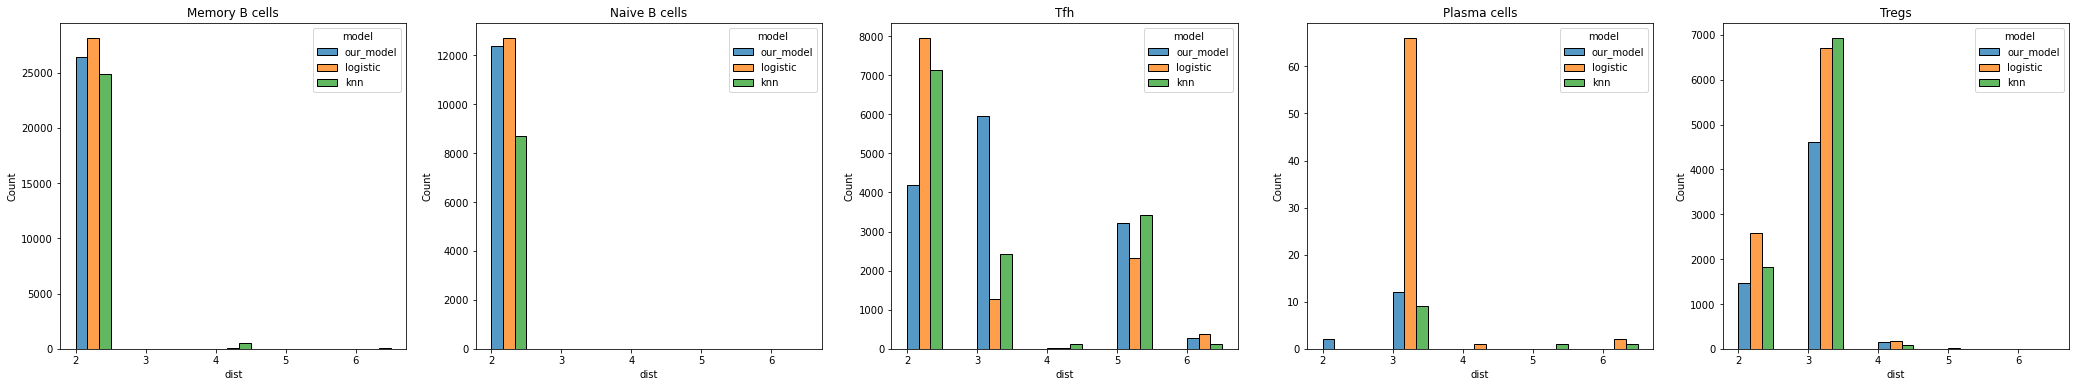

In [43]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
fig.set_size_inches(36, 6)
# ax0 = sns.barplot(data=df_acc, x='celltype', y='true_positive_rate', hue='model', ax=ax0)
# ax0.set_title('True Positive Rate for Each Cell Type')
# ax0.legend(loc='upper right')
sns.histplot(data=df_dist[df_dist['celltype'] == train_celltypes[0]], x="dist", multiple="dodge", hue="model", discrete=False, binwidth=0.5, binrange=(2,6.5), ax=ax1)
ax1.set_title('Memory B cells')
sns.histplot(data=df_dist[df_dist['celltype'] == train_celltypes[1]], x="dist", multiple="dodge", hue="model", discrete=False, binwidth=0.5, binrange=(2,6.5), ax=ax2)
ax2.set_title('Naive B cells')
sns.histplot(data=df_dist[df_dist['celltype'] == train_celltypes[2]], x="dist", multiple="dodge", hue="model", discrete=False, binwidth=0.5, binrange=(2,6.5), ax=ax3)
ax3.set_title('Tfh')
sns.histplot(data=df_dist[df_dist['celltype'] == train_celltypes[3]], x="dist", multiple="dodge", hue="model", discrete=False, binwidth=0.5, binrange=(2,6.5), ax=ax4)
ax4.set_title('Plasma cells')
sns.histplot(data=df_dist[df_dist['celltype'] == train_celltypes[4]], x="dist", multiple="dodge", hue="model", discrete=False, binwidth=0.5, binrange=(2,6.5), ax=ax5)
ax5.set_title('Tregs')
plt.show()